In [170]:
import pandas as pd
articles = pd.read_csv("../data/external/products.csv", dtype='string')

#how many rows are there in articles?
print(len(articles))

109444


In [171]:
print(articles['sku'].nunique())

109444


In [172]:
# number of unique groupid
print(articles['groupId'].nunique())


9158


In [173]:
articles = articles.drop(columns=['length', 'width', 'height', 'weight', 'fabricId', 'fabric'])

In [174]:
articles.sample()

,sku,groupId,brandId,status,name,description,brand,color,colorId,size,...,audience,audienceId,category,categoryId,priceSEK,priceEUR,priceNOK,priceDKK,quantity,incommingQuantity
76882,261047-0006,261047,100,inactive,Dorina Trosa Naomi 3-p,Naomi bekväm Brief- trosa i 3-p från Dorina. S...,Dorina,Multi,86,L,...,<NA>,<NA>,"Underkläder,Trosor","19,20",239,25.5,239,239,0,0


In [175]:
#count proportion of missing values in each column
articles.isnull().mean()

sku                  0.000000
groupId              0.000009
brandId              0.184441
status               0.000009
name                 0.009731
description          0.029851
brand                0.184441
color                0.169548
colorId              0.169548
size                 0.036576
sizeId               0.036576
audience             0.582608
audienceId           0.582608
category             0.049633
categoryId           0.049633
priceSEK             0.001508
priceEUR             0.006314
priceNOK             0.006131
priceDKK             0.006707
quantity             0.000009
incommingQuantity    0.000009
dtype: float64

In [176]:
articles = articles[
    (articles['status'] == "active") |
    ((articles['status'] == "inactive") & (articles['incommingQuantity'].astype(str) != "0"))
]

In [177]:
articles

,sku,groupId,brandId,status,name,description,brand,color,colorId,size,...,audience,audienceId,category,categoryId,priceSEK,priceEUR,priceNOK,priceDKK,quantity,incommingQuantity
89,888886,888886,<NA>,active,Extra,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,0,0,0,0,0,0
94,870023-0046,870023,50,active,Test hannah,Test hannah,Miss Mary,"Blå,Blå,Blå","269,269,269","46,46,46",...,"Dam,Dam,Dam","6,6,6","Jackor,Jackor,Jackor","2228,2228,2228",500,50,500,500,0,0
95,870023-0048,870023,50,active,Test hannah,Test hannah,Miss Mary,"Blå,Blå,Blå","269,269,269","48,48,48",...,"Dam,Dam,Dam","6,6,6","Jackor,Jackor,Jackor","2228,2228,2228",500,50,500,500,0,0
96,888880,888880,<NA>,active,extra,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,150,15,150,150,13,0
97,888885,888885,<NA>,active,Extra,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,0,0,0,0,1010,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109436,261248-6085,261248,50,active,<NA>,<NA>,Miss Mary,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,0
109438,260940-2095,260940,1,active,<NA>,<NA>,Abecita by Swegmark,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,0
109439,260487-B095,260487,174,active,<NA>,<NA>,Emilia,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,0
109441,261779-F075,261777,157,active,<NA>,<NA>,Triumph,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,0


## Name

In [182]:
import re
import pandas as pd

def _is_missing(s):
    return pd.isna(s) or str(s).strip().lower() in {"", "unknown", "nan", "<na>"}

COLORS = [
    "svart","vit","offwhite","off white","grå","ljusgrå","mörkgrå","blå","ljusblå","mellanblå","mörkblå","marin","navy","turkos",
    "grön","mörkgrön","ljusgrön","oliv","khaki","röd","vinröd","rosa","cerise","lila","plommon","gul","orange",
    "beige","sand","natur","brun","kaffe","kamel","taupe","multi","multicolor","flerfärgad",
    "silver","silvergrå","guld","grårosa","vitblå","gråbeige","offvit","gråbrun","gråsvart"
]
_color_alt = [r"off\s*white" if c=="off white" else re.escape(c) for c in COLORS]
COLOR_RE = re.compile(r"\b(" + "|".join(_color_alt) + r")\b", re.IGNORECASE)
DIM_RE = re.compile(r"\b\d{1,3}\s*[x×]\s*\d{1,3}\s*(?:cm|mm)?\b", re.IGNORECASE)
LONE_DIM_RE = re.compile(r"\b\d{1,4}(?:[.,]\d+)?\s*(?:cm|mm)\b", re.IGNORECASE)
DIAM_RE = re.compile(r"[Øø]\s*\d{1,3}\s*(?:cm|mm)\b", re.IGNORECASE)
WEIGHT_RE = re.compile(r"\b\d+(?:[.,]\d+)?\s*(?:kg|g)\b", re.IGNORECASE)
PACK_ANY_RE = re.compile(r"\b(\d+)\s*[- ]?\s*(?:pack|pk|st\.?|st|p|d|del(?:ar)?)\b", re.IGNORECASE)
LETTER_SIZE_RE = re.compile(r"\b(XXXL|XXL|XL|XS|S|M|L)\b", re.IGNORECASE)
BRA_SIZE_RE = re.compile(r"\b([A-H][0-9]{2})\b", re.IGNORECASE)
EU_SIZE_RE = re.compile(r"\b([2-6][0-9])\b(?!\s*(?:cm|mm))", re.IGNORECASE)

def _canon_pack(num, unit):
    u = unit.lower().replace("st.", "st")
    if u in {"pack", "p"}: return f"{num}-pack"
    if u == "pk": return f"{num} pk"
    if u == "st": return f"{num} st"
    return f"{num} delar"

def extract_color(txt):
    if not isinstance(txt, str): return None
    m = COLOR_RE.search(txt)
    return m.group(0).lower() if m else None

def extract_sizes(txt):
    if not isinstance(txt, str): return []
    out = DIM_RE.findall(txt)
    out += [m.group(0) for m in DIAM_RE.finditer(txt)]
    out += LONE_DIM_RE.findall(txt)
    out += WEIGHT_RE.findall(txt)
    out += [_canon_pack(m.group(1), (re.search(r"(pack|pk|st\.?|st|p|d|del(?:ar)?)", m.group(0), re.IGNORECASE) or ["pack"])[0])
            for m in PACK_ANY_RE.finditer(txt)]
    out += [m.group(0).upper() for m in LETTER_SIZE_RE.finditer(txt)]
    out += [m.group(0).upper() for m in BRA_SIZE_RE.finditer(txt)]
    out += [m.group(1) for m in EU_SIZE_RE.finditer(txt)]
    seen = set()
    uniq = []
    for t in out:
        k = t.lower().strip()
        if k not in seen:
            seen.add(k)
            uniq.append(t.strip())
    return uniq

def clean_name(txt, found_color=None, count_only=False):
    if not isinstance(txt, str): return (txt, 0) if count_only else txt
    s, n = txt, 0
    # Remove "Beskrivning " (with space) wherever it appears in the string
    s, n_beskrivning = re.subn(r"\bBeskrivning\s+", "", s)
    n += n_beskrivning
    if found_color: s, n1 = COLOR_RE.subn(" ", s); n += n1
    for pat in (DIM_RE, DIAM_RE, LONE_DIM_RE, WEIGHT_RE, PACK_ANY_RE, LETTER_SIZE_RE, BRA_SIZE_RE, EU_SIZE_RE):
        s, n1 = pat.subn(" ", s); n += n1
    n += sum(s.count(c) for c in ['\\','“','”','"'])
    s = s.replace("\\"," ").replace("“"," ").replace("”"," ").replace('"'," ")
    for pat in [r"\(\s*\)", r"\s*[-–/]\s*", r"\s{2,}"]:
        s, n1 = re.subn(pat, " ", s); n += n1
    s = s.strip(" -–,.;").strip()
    return (s, n) if count_only else s

for col in ["name", "color", "size"]:
    if col in articles.columns:
        articles[col] = articles[col].astype("string")

found_colors = articles["name"].apply(extract_color)
found_sizes = articles["name"].apply(extract_sizes)

mask_c = articles["color"].apply(_is_missing)
color_replacements = (mask_c & found_colors.notna()).sum()
articles.loc[mask_c & found_colors.notna(), "color"] = found_colors[mask_c & found_colors.notna()].str.lower()

mask_s = articles["size"].apply(_is_missing)
joined_sizes = found_sizes.apply(lambda xs: " / ".join(xs) if xs else pd.NA)
size_replacements = (mask_s & joined_sizes.notna()).sum()
articles.loc[mask_s & joined_sizes.notna(), "size"] = joined_sizes[mask_s & joined_sizes.notna()]

cleaned_and_counts = [clean_name(n, c, count_only=True) for n, c in zip(articles["name"], found_colors)]
articles["name"] = [x[0] for x in cleaned_and_counts]
name_replacement_count = sum(x[1] for x in cleaned_and_counts)

print(f"Color replacements made: {color_replacements}")
print(f"Size replacements made: {size_replacements}")
print(f"Name clean replacements made: {name_replacement_count}")

_unwanted_phrases = [
    "Övrigt","Frakt & exp. avgift","Aviavgift","Administrationsavgift","Express","Pf avg","Svarsporto","Krav outl",
    "Hemleverans 1","Hemleverans 2","Hemleverans 3","Hemleverans 4","Tillägg frakt","Krav outlöst","Returporto",
    "Katalogporto","Färgkarta porto","Manual till 293076","Rabatt"
]
_unwanted_re = re.compile("|".join(map(re.escape, _unwanted_phrases)), re.IGNORECASE)
mask_unwanted = articles["name"].astype(str).apply(lambda x: bool(_unwanted_re.search(x)))
removed_rows_count = mask_unwanted.sum()
articles = articles.loc[~mask_unwanted].reset_index(drop=True)
print(f"Rows removed due to unwanted phrases: {removed_rows_count}")

Color replacements made: 57
Size replacements made: 359
Name clean replacements made: 20544
Rows removed due to unwanted phrases: 19


In [183]:
# Concise sample of rows with NA name
na_name = articles[articles["name"].isna()]
na_name.sample(5)

,sku,groupId,brandId,status,name,description,brand,color,colorId,size,...,audience,audienceId,category,categoryId,priceSEK,priceEUR,priceNOK,priceDKK,quantity,incommingQuantity
6896,262143-75EF,262142,127,active,<NA>,<NA>,Glamorise,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,439,45.9,439,339,0,0
32699,270323-0046,270323,<NA>,active,<NA>,<NA>,<NA>,Blå,269,46,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,518,<NA>,0,0
6871,262150-L,262150,80,active,<NA>,<NA>,Swegmark,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,249,24.9,299,229,0,0
6833,262130-75E,262130,80,active,<NA>,<NA>,Swegmark,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,679,67.9,799,599,0,0
6835,262130-75C,262130,80,active,<NA>,<NA>,Swegmark,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,679,67.9,799,599,0,0


In [184]:
# Remove articles where name is NA and count how many were removed
removed_na_name_count = articles["name"].isna().sum()
articles = articles[articles["name"].notna()].reset_index(drop=True)
print(f"Rows removed due to NA name: {removed_na_name_count}")

Rows removed due to NA name: 192


## Color

In [185]:
# Show unique colorIds per color and counts (excluding NA colorId)
color_stats = articles[articles['colorId'].notna()].groupby('color', dropna=False)['colorId'].agg(['unique', 'count'])
print(f"{'color':20} {'colorIds':30} count")
for color, (ids, cnt) in color_stats.iterrows():
    print(f"{str(color):20} {str(list(ids)):30} {cnt}")

# Colors with >1 unique colorId (excluding NA)
multi = color_stats['unique'].apply(lambda x: len([i for i in x if pd.notna(i)]) > 1)
if multi.any():
    print("\nColors with more than one colorId:")
    for color, ids in color_stats.loc[multi, 'unique'].items():
        print(f"{color}: {[i for i in ids if pd.notna(i)]}")
else:
    print("\nNo color has more than one colorId.")

print(f"\nNumber of articles without colorId: {articles['colorId'].isna().sum()}")
print(f"Number of articles without color: {articles['color'].isna().sum()}")

# --- Additional analysis: Are there colorIds shared by multiple colors? ---
colorid_to_colors = articles[articles['colorId'].notna()].groupby('colorId', dropna=False)['color'].agg(['unique', 'count'])
multi_colorid = colorid_to_colors['unique'].apply(lambda x: len([i for i in x if pd.notna(i)]) > 1)
if multi_colorid.any():
    print("\ncolorIds used by more than one color:")
    for colorid, colors in colorid_to_colors.loc[multi_colorid, 'unique'].items():
        print(f"{colorid}: {[i for i in colors if pd.notna(i)]}")
else:
    print("\nNo colorId is used by more than one color.")

print(f"\nNumber of unique colorIds: {articles['colorId'].nunique(dropna=True)}")
print(f"Number of unique colors: {articles['color'].nunique(dropna=True)}")

color                colorIds                       count
Antracit             ['1852']                       177
Antracit,Antracit    ['1852,1852']                  43
Aqua                 ['1205']                       8
Aqua,Aqua            ['1205,1205']                  4
Aqua,Aqua,Aqua,Aqua,Aqua,Aqua ['660,660,660,660,1205,1205']  3
Aqua,Aqua,Aqua,Aqua,Aqua,Aqua,Aqua,Aqua ['660,660,660,660,1205,1205,1205,1205'] 1
Aubergine            ['3760']                       5
Beige                ['121']                        3272
Beige,Beige          ['121,121']                    1275
Beige,Beige,Beige    ['311,311,311', '121,121,121'] 10
Beige,Beige,Beige,Beige ['121,121,121,121']            4
Beige,Beige,Beige,Beige,Beige,Beige ['311,311,311,311,121,121']    2
Beige,Beige,Beige,Beige,Beige,Beige,Beige,Beige ['121,121,121,121,121,121,121,121', '311,311,311,311,121,121,121,121'] 3
Beige/brun           ['582']                        191
Blush,Blush,Blush    ['3188,3188,3188']             

In [186]:
# Color remapping 
def dedup(val):
    if pd.isna(val): return pd.NA
    seen = set()
    tokens = [x.strip() for x in str(val).split(',') if x.strip() and not (x in seen or seen.add(x))]
    return ','.join(tokens) if tokens else pd.NA

def clean_color_name(color):
    if pd.isna(color): return color
    return str(color).replace('/', '-').lower()

def merge_comma_colors(color):
    if pd.isna(color) or ',' not in str(color): return color
    individual_colors = [c.strip() for c in str(color).split(',') if c.strip()]
    best_color = max(individual_colors, key=lambda c: len(articles[articles['color'] == c]), default=color)
    return best_color

# Clean and normalize colors
articles['color'] = articles['color'].apply(dedup).apply(clean_color_name).apply(merge_comma_colors).astype('string')
articles['colorId'] = articles['colorId'].apply(dedup).astype('string')

# Merge rare colors into major categories
rare_color_merges = [
    ("blush", "rosa"), ("cerise", "rosa"), ("grå-rosa", "rosa"), ("grålila", "lila"),
    ("havsblå", "blå"), ("jeansblå", "blå"), ("klarblå", "blå"), ("lavendel", "lila"),
    ("ljus beige", "beige"), ("ljus blå", "blå"), ("ljusgrå mix", "grå"), ("ljusturkos", "turkos"),
    ("marinblå", "marin"), ("mellanblå", "blå"), ("mellanbrun", "brun"), ("mellangrå", "grå"),
    ("mellanrosa", "rosa"), ("mintgrön", "grön"), ("mörkbrun", "brun"), ("mörkröd", "röd"),
    ("natur", "beige"), ("oblekt", "vit"), ("oliv", "grön"), ("orange mix", "orange"),
    ("puderrosa", "rosa"), ("rost", "röd"), ("svart-silver", "svart"), ("transparent", "vit"),
    ("violett", "lila"), ("off white", "offwhite"), ("silverfärgad", "silver"), ("guldgul", "gul"),
    ("ljusrosa", "rosa"), ("gråsvart", "svart"), ("gråbeige", "beige"), ("gråbrun", "brun"),
    ("vitblå", "blå"), ("grårosa", "rosa"), ("plommonlila", "lila"), ("vinröd", "röd"),
    ("multicolor", "multi"), ("flerfärgad", "multi"), ("jeans", "blå"), ("himmelblå", "ljusblå"),
    ("pärlvit", "vit"), ("naturvit", "vit"), ("sandfärgad", "sand"), ("kaffe", "brun"),
    ("kamel", "brun"), ("taupe", "brun"), ("offvit", "vit"), ("beigegrå", "beige")
]


for rare_color, target_color in rare_color_merges:
    mask = articles['color'] == rare_color
    if mask.any():
        articles.loc[mask, 'color'] = target_color
        print(f"'{rare_color}' → '{target_color}' ({mask.sum()} articles)")

# Remap colors to single colorIds
color_to_colorids = articles[articles['color'].notna()].groupby('color')['colorId'].agg(list)
multi_color = color_to_colorids[color_to_colorids.apply(lambda x: len(set([i for i in x if pd.notna(i)])) > 1)]

for color, colorid_list in multi_color.items():
    main_colorid = articles.loc[articles['color'] == color, 'colorId'].value_counts().idxmax()
    articles.loc[articles['color'] == color, 'colorId'] = main_colorid
    print(f"'{color}': {set(colorid_list)} → '{main_colorid}'")

# Fill NA in color column with 'unknown' in place
#articles['color'] = articles['color'].fillna('unknown')

'blush' → 'rosa' (1 articles)
'cerise' → 'rosa' (1 articles)
'grå-rosa' → 'rosa' (5 articles)
'grålila' → 'lila' (1 articles)
'havsblå' → 'blå' (1 articles)
'jeansblå' → 'blå' (1 articles)
'klarblå' → 'blå' (1 articles)
'lavendel' → 'lila' (1 articles)
'ljus beige' → 'beige' (1 articles)
'ljus blå' → 'blå' (1 articles)
'ljusgrå mix' → 'grå' (1 articles)
'ljusturkos' → 'turkos' (1 articles)
'marinblå' → 'marin' (1 articles)
'mellanbrun' → 'brun' (1 articles)
'mellangrå' → 'grå' (1 articles)
'mellanrosa' → 'rosa' (1 articles)
'mintgrön' → 'grön' (3 articles)
'natur' → 'beige' (3 articles)
'oblekt' → 'vit' (1 articles)
'oliv' → 'grön' (1 articles)
'orange mix' → 'orange' (1 articles)
'puderrosa' → 'rosa' (13 articles)
'rost' → 'röd' (4 articles)
'svart-silver' → 'svart' (1 articles)
'transparent' → 'vit' (1 articles)
'ljusrosa' → 'rosa' (245 articles)
'plommonlila' → 'lila' (31 articles)
'vinröd' → 'röd' (208 articles)
'kamel' → 'brun' (1 articles)
'taupe' → 'brun' (111 articles)
'aqua': 

In [187]:
articles['color'].isna().sum()

814

In [188]:
import re

# Build a set of all known color names (including rare and base colors)
base_colors = set([target for _, target in rare_color_merges])
rare_colors = set([rare for rare, _ in rare_color_merges])
all_colors = base_colors | rare_colors

# Add also all unique colors already present in the data (excluding NA)
all_colors |= set(articles['color'].dropna().unique())

# Lowercase all for matching
all_colors = set([c.lower() for c in all_colors if isinstance(c, str)])

def extract_color_from_description(desc):
    if pd.isna(desc) or not isinstance(desc, str):
        return pd.NA
    desc_lower = desc.lower()
    # Find all color words in description (whole word match)
    found = []
    for color in sorted(all_colors, key=lambda x: -len(x)):  # match longer first
        # Use word boundaries, but allow for e.g. "ljusblå" (no space)
        if re.search(r'\b' + re.escape(color) + r'\b', desc_lower):
            found.append(color)
        elif color in desc_lower:
            found.append(color)
    if not found:
        return pd.NA
    # If more than one, pick the first one found in text order
    # Find the earliest occurrence
    found_positions = [(desc_lower.find(color), color) for color in found]
    found_positions = [fp for fp in found_positions if fp[0] != -1]
    if not found_positions:
        return pd.NA
    found_positions.sort()
    chosen_color = found_positions[0][1]
    # Map rare color to base color if needed
    for rare, base in rare_color_merges:
        if chosen_color == rare:
            return base
    return chosen_color

# Only fill where color is NA or 'unknown'
mask_missing_color = articles['color'].isna() | (articles['color'] == 'unknown')
articles.loc[mask_missing_color, 'color'] = articles.loc[mask_missing_color, 'description'].apply(extract_color_from_description).astype('string')


In [189]:
color_counts = articles['color'].value_counts(dropna=True)
print(f"Unique colors ({len(color_counts)}):")
for color, count in color_counts.items():
    print(f"{color}: {count}")


Unique colors (71):
svart: 8666
vit: 6451
beige: 4675
rosa: 1486
blå: 1061
marin: 885
röd: 781
off-white: 731
champagne: 705
mörkblå: 682
grön: 649
brun: 582
grå: 477
svart-grå: 398
vit-beige: 357
vanilj: 312
mörkgrå: 287
turkos: 225
antracit: 220
lila: 208
beige-brun: 191
creme: 182
korall: 174
ljusgrå: 171
svart-vit: 166
duvblå: 99
nougat: 96
ljusgrön: 96
sand: 82
multi: 79
svart-mönstrad: 71
denim: 68
rosa-vit: 64
linne: 61
petrol: 60
gråmelerad: 56
svart-blå: 47
ljusblå: 47
pralin: 42
mullvad: 37
blå-vit: 29
aqua: 16
gul: 16
kaki: 14
gammalrosa: 13
mörkgrön: 13
gråblå: 12
grå-svart: 11
ljung: 11
svart-röd: 11
grön-svart: 10
indigo: 10
hallon: 9
mörk cerise: 9
blå-mönstrad: 8
svart-marinmönstrad: 7
orange: 7
blågrå: 6
lila-rosa: 6
greige: 6
aubergine: 5
ljusbrun: 4
olivgrön: 4
silver: 3
mörkrosa: 3
grå-vit: 2
guld: 2
cognac: 2
blå-grön: 1
offwhite: 1
ljusgul: 1


In [190]:
articles['color'].isna().sum()

549

In [191]:
articles[articles['color'].isna()].sample(10)

,sku,groupId,brandId,status,name,description,brand,color,colorId,size,...,audience,audienceId,category,categoryId,priceSEK,priceEUR,priceNOK,priceDKK,quantity,incommingQuantity
14616,261581-D085,260219,80,active,Bh utan bygel Cotton Bloom,Mjuk-bh från Swegmark tillverkad av ekologisk ...,Swegmark,<NA>,<NA>,D85,...,Dam,6,"Bh utan bygel,Bh,Underkläder,Bh utan bygel","50,27,19,50",549,54.9,649,499,0,0
2535,350600,350600,120,active,Fyndpaket Hobbyhörnan,Överraskningspaket med pysselglädje!\nOBS: vår...,Ateljé Margaretha,<NA>,<NA>,<NA>,...,<NA>,<NA>,"Hobbyhörnan,Hobbyhörnan,Hobbyhörnan,Pysselset,...","172,172,172,241,241,241",798,79.8,798,798,77,0
19782,PM25DK,PM25DK,5,active,Betjeningsvejledning,<NA>,beurer,<NA>,<NA>,<NA>,...,<NA>,<NA>,Träning & motion,1455,0,<NA>,<NA>,0,494,0
2203,430393,430393,258,active,Pussel Venedig 500 Bitar,Detta pussel är mer än bara en tidsfördriv. De...,Trefl,<NA>,<NA>,<NA>,...,<NA>,<NA>,"Hobbyhörnan,Hobbyhörnan,Hobbyhörnan,Pussel,Pus...","172,172,172,365,365,365,499,499,499",159,14.9,189,139,6,0
23347,290149,290149,27,active,Tåsspridare,Elastiskt skydd med både tåspridare och skydd ...,Good Living,<NA>,<NA>,2-pack,...,<NA>,<NA>,"Fotvård,Fotvård,Stödartiklar,Stödartiklar","1981,1981,1460,1460",119,11.9,139,119,335,0
10484,262817-3080,263343,50,active,Bh utan bygel Lovely Jaquard,En bh att älska! En omedelbar favorit från Mis...,Miss Mary,<NA>,<NA>,C80,...,Dam,6,"Bh utan bygel,Bh,Underkläder,Bh utan bygel","50,27,19,50",549,54.99,629,399,0,0
19722,BC32FI,BC32FI,5,active,Käyttöohje,<NA>,beurer,<NA>,<NA>,<NA>,...,<NA>,<NA>,Vardagshjälpmedel,497,0,0,<NA>,<NA>,0,0
11983,250266-0038,250266,<NA>,active,Quiltad jacka,<NA>,<NA>,<NA>,<NA>,38,...,<NA>,<NA>,<NA>,<NA>,198,24.75,198,198,0,0
14657,261581-B095,260219,80,active,Bh utan bygel Cotton Bloom,Mjuk-bh från Swegmark tillverkad av ekologisk ...,Swegmark,<NA>,<NA>,B95,...,Dam,6,"Bh utan bygel,Bh,Underkläder,Bh utan bygel","50,27,19,50",549,54.9,649,499,0,0
11978,250266-0050,250266,<NA>,active,Quiltad jacka,<NA>,<NA>,<NA>,<NA>,50,...,<NA>,<NA>,<NA>,<NA>,218,26.75,218,218,0,0


# Fabric

In [192]:
import re
import unicodedata
import pandas as pd

# --- 1) Din tyglista (svenska, engelska). Kortad här för överskådlighet: lägg in hela din lista. ---
fabrics_pairs = [
    # Naturfibrer
    ("bomull", "cotton"), ("linne", "linen"), ("ull", "wool"),
    ("kashmir", "cashmere"), ("merinoull", "merino wool"),
    ("alpaca", "alpaca"), ("mohair", "mohair"), ("silke", "silk"),
    ("hampa", "hemp"), ("jute", "jute"), ("raffia", "raffia"),
    ("bambu", "bamboo fabric"), ("bananfiber", "banana fiber"),
    ("kokosfiber", "coir"), 
    # Regenererade/syntet
    ("polyester", "polyester"), ("nylon", "nylon"), ("akryl", "acrylic"),
    ("spandex", "spandex"), ("elastan", "elastane"), ("acetat", "acetate"),
    ("viskos", "viscose"), ("modal", "modal"), ("lyocell", "lyocell"),
    ("triacetat", "triacetate"), ("neopren", "neoprene"), ("mikrofiber", "microfiber"),
    # Tygtyper
    ("frotté", "terry cloth"), ("satin", "satin"), ("sammet", "velvet"),
    ("flanell", "flannel"), ("denim", "denim"), ("manchester", "corduroy"),
    ("fleece", "fleece"), ("jersey", "jersey knit"), ("interlock", "interlock knit"),
    ("trikå", "tricot knit"), ("gabardin", "gabardine"), ("tweed", "tweed"),
    ("canvas", "canvas"), ("poplin", "poplin"), ("oxford", "oxford cloth"),
    ("seersucker", "seersucker"), ("taft", "taffeta"), ("tyll", "tulle"),
    ("mesh", "mesh"), ("organza", "organza"), ("brokad", "brocade"),
    ("batist", "batiste"), ("crêpe", "crepe"), ("georgette", "georgette"),
    ("muslin", "muslin"),
    # Broderi/väv (dina extra)
    ("färgtryckt väv", "printed weave"),
    ("bakgrundstryckt", "background printed fabric"),
    ("stramalj", "mono canvas"),
    ("aida", "aida cloth"),
    ("ritade broderier", "pre-printed embroidery fabric"),
    ("ullgarn", "wool yarn"),
    ("alpackagarn", "alpaca yarn"),
    ("rya", "rya"),
    # Läder/päls
    ("skinn", "leather"), ("mocka", "suede"),
    ("päls", "fur"), ("fuskpäls", "faux fur"),
    # Tekniska
    ("softshell", "softshell"), ("gore-tex", "gore-tex"),
    ("kevlar", "kevlar"), ("tyvek", "tyvek"),
    # Traditionella/etniska
    ("batik", "batik"), ("ikat", "ikat"), ("khadi", "khadi"), ("madras", "madras"),
    ("shantung", "shantung silk"), ("dupion", "dupioni silk"),
    ("kente", "kente cloth"), ("ankara", "ankara / african wax print"),
    ("tartan", "tartan / plaid"), ("paisley-tyg", "paisley fabric"),
    ("bogolan", "mud cloth"), ("adire", "adire cloth")
]

# --- 2) Synonymer/alias -> kanoniskt svenskt namn ---
synonyms = {
    "läder": "skinn",
    "leather": "skinn",
    "suede": "mocka",
    "rayon": "viskos",
    "lycra": "elastan",
    "tencel": "lyocell",
    "corduroy": "manchester",
    "oxford cloth": "oxford",
    "jersey": "jersey",            # engelska varianten
    "jersey knit": "jersey",
    "tricot": "trikå",
    "neoprene": "neopren",
    "microfiber": "mikrofiber",
    "faux fur": "fuskpäls",
    "fur": "päls",
    "wool": "ull",
    "alpaca": "alpaca",
    "wool yarn": "ullgarn",
    "alpaca yarn": "alpackagarn",
    "printed weave": "färgtryckt väv",
    "background printed fabric": "bakgrundstryckt",
    "aida cloth": "aida",
    "pre-printed embroidery fabric": "ritade broderier",
    "mono canvas": "stramalj",
    "terry cloth": "frotté",
    "coir": "kokosfiber",
    "gore tex": "gore-tex",
    "goretex": "gore-tex",
}

# ----------------------------
# Build canonical maps
# ----------------------------
alias_to_canonical = {}

def add_alias(alias, canonical):
    alias = alias.strip().lower()
    if alias:
        alias_to_canonical[alias] = canonical

# 1) From your (sv, en) fabric pairs
for sv, en in fabrics_pairs:
    sv_can = sv.strip().lower()
    add_alias(sv_can, sv_can)              # Swedish canonical
    add_alias(en.strip().lower(), sv_can)  # English alias -> Swedish canonical

# 2) From your synonyms (any lang) -> Swedish canonical
for alias, canon in synonyms.items():
    add_alias(alias, canon)

# Optional: Swedish -> English map (for a parallel English list)
sv_to_en = {sv.strip().lower(): en.strip().lower() for sv, en in fabrics_pairs}

# ----------------------------
# Normalization
# ----------------------------
def strip_accents(s: str) -> str:
    if not isinstance(s, str):
        return s
    return ''.join(ch for ch in unicodedata.normalize('NFKD', s) if not unicodedata.combining(ch))

# ----------------------------
# Single union regex builder
# ----------------------------
def alias_to_fragment(alias: str) -> str:
    """
    Turn an alias like 'gore tex' or 'gore-tex' into a regex fragment that accepts
    optional space/hyphen between tokens. We avoid multiplying aliases.
    """
    parts = re.split(r'[ \-]+', alias)
    parts = [p for p in parts if p]
    return r'[ -]?'.join(re.escape(p) for p in parts) if parts else ""

# Prepare items, prefer multi-word & longer first to reduce overlaps
alias_items = []
for alias, canon in alias_to_canonical.items():
    frag = alias_to_fragment(alias)
    if not frag:
        continue
    token_cnt = len([p for p in re.split(r'[ \-]+', alias) if p])
    raw_len = len(alias.replace(" ", "").replace("-", ""))
    alias_items.append((canon, alias, frag, token_cnt, raw_len))

# Deduplicate by (canonical, fragment) to keep alternation compact
seen = set()
uniq_items = []
for canon, alias, frag, token_cnt, raw_len in alias_items:
    key = (canon, frag)
    if key in seen:
        continue
    seen.add(key)
    uniq_items.append((canon, alias, frag, token_cnt, raw_len))

# Sort: more tokens first, then longer
uniq_items.sort(key=lambda x: (-x[3], -x[4], x[1]))

# Build one compiled union regex with named groups
ALNUM = "0-9a-z"  # after strip_accents, å/ä/ö are decomposed
suffix = r'(?:er|ar|or|en|et|n|s|es)?'

group_to_canon = {}
group_patterns = []
for i, (canon, alias, frag, *_ ) in enumerate(uniq_items):
    gname = f"g{i}"
    group_to_canon[gname] = canon
    group_patterns.append(fr"(?P<{gname}>{frag}{suffix})")

UNION_PATTERN = re.compile(
    rf"(?<![{ALNUM}])(?:{'|'.join(group_patterns)})(?![{ALNUM}])",
    flags=re.IGNORECASE
)

# ----------------------------
# Extractor (single pass per row)
# ----------------------------
def extract_fabrics_fast(desc: str, return_empty_list=False):
    """
    Return list of canonical Swedish fabric names in text order (deduped).
    If no match: pd.NA (default) or [] if return_empty_list=True (useful for explode).
    """
    if pd.isna(desc) or not isinstance(desc, str):
        return [] if return_empty_list else pd.NA

    text = strip_accents(desc.lower())
    matches = []
    for m in UNION_PATTERN.finditer(text):
        canon = group_to_canon[m.lastgroup]
        s, e = m.span()
        matches.append((s, e, canon))

    if not matches:
        return [] if return_empty_list else pd.NA

    # Resolve overlaps: keep earliest, prefer longer spans; dedup canonicals
    matches.sort(key=lambda x: (x[0], -(x[1]-x[0])))
    accepted, seen_canon = [], set()
    for s, e, c in matches:
        if any(not (e <= s2 or s >= e2) for s2, e2, _ in accepted):
            continue
        if c in seen_canon:
            continue
        accepted.append((s, e, c))
        seen_canon.add(c)

    accepted.sort(key=lambda x: x[0])
    out = [c for _, _, c in accepted]
    return out if out else ([] if return_empty_list else pd.NA)

# ----------------------------
# Apply to your DataFrame
# ----------------------------
USE_EMPTY_LIST = False  # set True if you plan to articles.explode("fabrics")

articles["fabrics"] = articles["description"].apply(
    lambda x: extract_fabrics_fast(x, return_empty_list=USE_EMPTY_LIST)
)

# Primary fabric (first match by text order)
articles["fabric_primary"] = articles["fabrics"].apply(
    lambda xs: (xs[0] if isinstance(xs, list) and xs else pd.NA)
)

# Optional: parallel English list
def to_english_list(xs):
    if not isinstance(xs, list):
        return pd.NA
    out = [sv_to_en.get(sv, sv) for sv in xs]
    return out if out else pd.NA

articles["fabrics_en"] = articles["fabrics"].apply(to_english_list)

### Inspect and transform Category and Category ID

In [193]:
# Show unique categoryIds per category (excluding NA)
cat_stats = articles[articles['categoryId'].notna()].groupby('category')['categoryId'].agg(['unique', 'count'])
print(f"{'category':50} {'categoryIds':40} count")
for cat, (ids, cnt) in cat_stats.iterrows():
    # Format the list of ids as a string, not using a format specifier for the list
    ids_str = str(list(ids))
    print(f"{cat:50} {ids_str:40} {cnt}")

# Categories with >1 unique categoryId
multi_cat = cat_stats['unique'].apply(lambda x: sum(pd.notna(x)) > 1)
if multi_cat.any():
    print("\nCategories with >1 categoryId:")
    for cat, ids in cat_stats.loc[multi_cat, 'unique'].items():
        print(f"{cat}: {[i for i in ids if pd.notna(i)]}")
else:
    print("\nNo category has >1 categoryId.")

print(f"\nArticles without categoryId: {articles['categoryId'].isna().sum()}")
print(f"Articles without category: {articles['category'].isna().sum()}")

category                                           categoryIds                              count
Accessoarer                                        ['454']                                  4
Accessoarer,Accessoarer,Bh,Bh,Underkläder,Underkläder,Bh-tillbehör,Bh-tillbehör ['454,454,27,27,19,19,691,691']          1
Accessoarer,Accessoarer,Handskar & vantar,Handskar & vantar ['454,454,1415,1415']                    1
Accessoarer,Halsdukar & sjalar                     ['454,7']                                1
Accessoarer,Handskar & vantar                      ['454,1415']                             2
Accessoarer,Herr,Kepsar & mössor                   ['454,162,1447']                         2
Accessoarer,Kepsar & mössor                        ['454,1447']                             6
Accessoarer,Kepsar & mössor,Accessoarer,Kepsar & mössor ['454,1447,454,1447']                    2
Accessoarer,Väskor                                 ['454,200']                              1
Bad,Bad,Dusch

In [194]:
# category↔ID mapping

def dedup_csv(s):
    if pd.isna(s): return pd.NA
    out, seen = [], set()
    for t in map(str.strip, str(s).split(',')):
        if t and t not in seen: seen.add(t); out.append(t)
    return ','.join(out) if out else pd.NA

def toks(s):
    return [t.strip() for t in str(s).split(',') if t.strip()] if pd.notna(s) else []

articles['category']   = articles['category'].apply(dedup_csv).astype('string')
articles['categoryId'] = articles['categoryId'].apply(dedup_csv).astype('string')

pairs, mismatched = [], 0
for cat, cid in articles[['category','categoryId']].dropna().itertuples(index=False):
    ct, it = toks(cat), toks(cid)
    n = min(len(ct), len(it))
    if n == 0: continue
    if len(ct) != len(it): mismatched += 1
    pairs.extend(zip(ct[:n], it[:n]))

if not pairs:
    print("No category↔id pairs available.")
else:
    dfp = pd.DataFrame(pairs, columns=['cat_tok','id_tok'])
    token2id = (dfp.groupby(['cat_tok','id_tok']).size()
                  .reset_index(name='n')
                  .sort_values(['cat_tok','n','id_tok'], ascending=[True,False,True])
                  .drop_duplicates('cat_tok')
                  .set_index('cat_tok')['id_tok'])

    def rebuild_ids(cat):
        ct = toks(cat)
        mapped = [token2id.get(t, pd.NA) for t in ct if t in token2id]
        return ','.join(mapped) if mapped else pd.NA

    articles['categoryId'] = articles['category'].apply(rebuild_ids).astype('string')

# Replace missing category values with 'unknown' in place
articles['category'] = articles['category'].fillna('unknown').astype('string')

# missing flag
articles['category_missing'] = (articles['category'] == 'unknown').astype('int8')

# keep category_missing next to 'category'
def _move_after(df, cols, after):
    cols_all = list(df.columns)
    for c in cols:
        if c in cols_all: cols_all.remove(c)
    i = cols_all.index(after) + 1 if after in cols_all else len(cols_all)
    return df[cols_all[:i] + cols + cols_all[i:]]

articles = _move_after(articles, ['category_missing'], 'category')

# Stats
pairs2 = []
for cat, cid in articles[['category','categoryId']].dropna().itertuples(index=False):
    ct, it = toks(cat), toks(cid)
    n = min(len(ct), len(it))
    pairs2.extend(zip(ct[:n], it[:n]))
d2 = pd.DataFrame(pairs2, columns=['cat_tok','id_tok'])

cat_stats = d2.groupby('cat_tok')['id_tok'].agg(lambda s: sorted(pd.unique(s.dropna()))).reset_index(name='unique_ids')
cat_stats['count'] = d2.groupby('cat_tok')['id_tok'].size().values

print(f"Mismatched token/id lengths: {mismatched}")
print(f"\n{'category token':40} {'unique_ids':25} count")
for _, r in cat_stats.sort_values('count', ascending=False).iterrows():
    print(f"{r['cat_tok'][:40]:40} {str(r['unique_ids'])[:25]:25} {int(r['count'])}")

multi = cat_stats['unique_ids'].apply(len) > 1
if multi.any():
    print("\nTokens mapping to >1 id:")
    for _, r in cat_stats[multi].iterrows():
        print(f"  {r['cat_tok']}: {r['unique_ids']}")
else:
    print("\n✓ Every category token maps to a single id.")

id_stats = d2.groupby('id_tok')['cat_tok'].agg(lambda s: sorted(pd.unique(s.dropna()))).reset_index(name='tokens')
multi_id = id_stats['tokens'].apply(len) > 1
if multi_id.any():
    print("\nIds used by multiple tokens:")
    for _, r in id_stats[multi_id].iterrows():
        print(f"  {r['id_tok']}: {r['tokens'][:10]}{' ...' if len(r['tokens'])>10 else ''}")
else:
    print("\n✓ No id is shared by multiple tokens.")

print(f"\nUnique categoryIds: {articles['categoryId'].str.split(',').explode().nunique(dropna=True)}")
print(f"Unique category tokens: {d2['cat_tok'].nunique(dropna=True)}")


Mismatched token/id lengths: 2

category token                           unique_ids                count
Underkläder                              ['19']                    26913
Bh                                       ['27']                    23717
Bh utan bygel                            ['50']                    17177
Bygel-bh                                 ['223']                   7848
Sport-bh                                 ['618']                   3343
Badkläder                                ['470']                   2338
Trosor                                   ['20']                    1587
Framknäppt bh                            ['189']                   1585
Bikini                                   ['736']                   1414
Protes-bh                                ['122']                   1003
Baddräkter                               ['469']                   880
Body                                     ['450']                   691
Överdelar                     

## Audience

In [195]:
print("Unique values of 'audience' and their counts:")
print(articles['audience'].value_counts(dropna=False))


Unique values of 'audience' and their counts:
audience
Dam                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            15828
<NA>                                                                                                                                                                                                                                                                                                                                                                                                        

In [196]:
# Audience cleanup

import re
import pandas as pd

AUD2ID = {'dam':'6','herr':'15','baby & barn':'12','barn & ungdom':'42','generic':'99','hemmet':'222'}

# 1) normalize what’s already there
def norm_audience(a):
    if pd.isna(a): return pd.NA
    toks = {t.strip().lower() for t in str(a).split(',') if t.strip()}
    if any('dam' in t for t in toks):  # “dam” anywhere wins
        return 'dam'
    keep = [t for t in toks if t in AUD2ID]
    return ','.join(keep) if keep else pd.NA

def to_ids(a):
    if pd.isna(a): return pd.NA
    ids = sorted({AUD2ID[t] for t in a.split(',') if t in AUD2ID}, key=int)
    return ','.join(ids) if ids else pd.NA

articles['audience'] = articles['audience'].apply(norm_audience).astype('string')

# 2) fill missing using category text (substring matches, ignore “REA” as a token)
DAM = [
    'dam','bh','trosor','underkläder','body','bodykorselett','korsett','korsetter',
    'klänning','klänningar','tunika','tunikor','topp','toppar','kjol','kjolar',
    'byxa','byxor','blus','blusar','nattlinne','bikinibh','bikini','t-shirt-bh',
    'minimizer','kofta','koftor','väst','västar','skor','väskor','sjalar'
]
HEM = [
    'frottéhanddukar','badlakan','bad','badrumsmattor','kökshanddukar','vaxdukar','dukar',
    'pläd','plädar','kanallängder','kanalkappa','gardiner','påslakanset','bädd',
    'lakan','örngott','hemtextil','kuddfodral','överkast','gardinstänger','kökshjälpmedel',
    'dekorationer','metervara','prydnadssaker','belysning','servetter'
]
GEN = [
    'inkontinens','stödartiklar','vardagshjälpmedel','rollator','rollatorer','stödstrumpor',
    'skotillbehör','fotvård','hobbyhörnan','pussel','sytillbehör','symaskiner','lust',
    'massage','synhjälpmedel','medicin','böcker','halkskydd','träning & motion'
]
HER = ['herr','skjorta','skjortor','kostym','kavaj','boxer']

REA_TOKEN = re.compile(r'(^|,)\s*rea\s*(?=,|$)')

def strip_rea(s):
    s = s.lower()
    s = REA_TOKEN.sub(lambda m: ',' if m.group(1) else '', s)
    return re.sub(r',+', ',', s).strip(', ').strip()

def classify(cat):
    if pd.isna(cat): return pd.NA
    s = strip_rea(str(cat))
    if not s: return pd.NA
    if any(h in s for h in DAM): return 'dam'
    if any(h in s for h in HER): return 'herr'
    if any(h in s for h in HEM): return 'hemmet'
    if any(h in s for h in GEN): return 'generic'
    return pd.NA

na_mask = articles['audience'].isna()
fill = articles.loc[na_mask, 'category'].apply(classify)
idx = fill.dropna().index
articles.loc[idx, 'audience'] = fill.loc[idx]

# 3) ids and missing flag; keep columns together
articles['audienceId']       = articles['audience'].apply(to_ids).astype('string')
articles['audience_missing'] = articles['audience'].isna().astype('int8')

def move_after(df, cols, after):
    cols_all = list(df.columns)
    for c in cols:
        if c in cols_all: cols_all.remove(c)
    i = cols_all.index(after) + 1 if after in cols_all else len(cols_all)
    return df[cols_all[:i] + cols + cols_all[i:]]

articles = move_after(articles, ['audienceId','audience_missing'], 'audience')

# tiny report
filled = len(idx); total = int(na_mask.sum())
print(f"Filled audience for {filled}/{total} ({filled/max(total,1):.1%}). "
      f"Dam={int((articles.loc[idx,'audience']=='dam').sum())}, "
      f"Herr={int((articles.loc[idx,'audience']=='herr').sum())}, "
      f"Hemmet={int((articles.loc[idx,'audience']=='hemmet').sum())}, "
      f"Generic={int((articles.loc[idx,'audience']=='generic').sum())}.")


Filled audience for 9053/9483 (95.5%). Dam=7921, Herr=2, Hemmet=730, Generic=400.


In [197]:
articles['audience'] = articles['audience'].fillna('unknown').astype('string')

## Size

In [198]:
# Ensure string dtype
articles['size'] = articles['size'].astype('string')
articles['sizeId'] = articles['sizeId'].astype('string')

# Unique sizeIds per size
size_stats = (articles[articles['sizeId'].notna()]
              .groupby('size', dropna=False)['sizeId']
              .agg(unique=lambda s: list(pd.unique(s)), count='size')
              .sort_values('count', ascending=False))

print(f"{'size':50} {'sizeIds':40} count")
for size, row in size_stats.iterrows():
    print(f"{size:50} {str(row['unique']):40} {row['count']}")

# Sizes with >1 sizeId
multi_size = size_stats['unique'].apply(lambda ids: sum(pd.notna(i) for i in ids) > 1)
if multi_size.any():
    print("\nSizes with >1 sizeId:")
    for size, ids in size_stats.loc[multi_size, 'unique'].items():
        print(f"{size}: {[i for i in ids if pd.notna(i)]}")
else:
    print("\nNo size has >1 sizeId.")

# sizeIds shared by multiple sizes
rev = (articles[articles['sizeId'].notna()]
       .groupby('sizeId')['size']
       .agg(unique=lambda s: list(pd.unique(s)), count='size'))
multi_id = rev['unique'].apply(lambda ss: sum(pd.notna(x) for x in ss) > 1)
if multi_id.any():
    print("\nsizeIds shared by multiple sizes:")
    for sid, sizes in rev.loc[multi_id, 'unique'].items():
        print(f"{sid}: {[s for s in sizes if pd.notna(s)]}")
else:
    print("\nNo sizeId shared by multiple sizes.")

print(f"\nArticles without sizeId: {articles['sizeId'].isna().sum()}")
print(f"Articles without size: {articles['size'].isna().sum()}")


size                                               sizeIds                                  count
C90                                                ['62']                                   449
D90                                                ['69']                                   447
D85                                                ['68']                                   447
C85                                                ['28']                                   446
D80                                                ['67']                                   444
C80                                                ['60']                                   440
D95                                                ['70']                                   432
C95                                                ['63']                                   427
E85                                                ['77']                                   425
E90                                   

In [199]:
# --- cleanup & mapping for size ---
import re

NOISE_TOKENS = {
    '***missing***','rosa','svart','blå','offwhite','vinröd','greige',
    'kuddfodral','påslakan','tomte','ostbricka','plommonlila'
}
SIZE_PATTERNS = [
    r'^\d{2}$', r'^\d{2}/\d{2}$', r'^[A-Z]{1,2}/?[A-Z]{0,2}\d{2}$',
    r'^\d{2}[A-Z]/[A-Z]$', r'^[A-Z]{1,3}$', r'^\d{2}x\d{2,3}\s*cm$',
    r'^\d{2,3}x\d{2,3}\s*cm$', r'^\d+(\.\d+)?\s*mm$', r'^\d{2}x\d{2}$',
    r'^\d+$', r'^\d+[- ]?PACK$', r'^[A-Z]/[A-Z]\d{2}$'
]
size_re = re.compile('|'.join(f'(?:{p})' for p in SIZE_PATTERNS), re.I)

def canon_size_token(t):
    t = t.strip().replace('×','x').replace(' X ','x').replace(' x ','x')
    t = re.sub(r'\s*x\s*', 'x', t)
    t = re.sub(r'\s+cm\b', ' cm', t, flags=re.I)
    t = re.sub(r'\s+mm\b', ' mm', t, flags=re.I)
    t = t.replace(',', '.') if re.search(r'\d,\d', t) else t
    t = t.upper() if t.lower() in {'xs','s','m','l','xl','xxl','3xl','4xl','5xl','6xl','one size'} else t
    t = t.replace('–','-').replace('—','-')
    t = t.replace('-', '/') if re.fullmatch(r'\d{2}-\d{2}', t) else t
    return t

def is_size_token(t):
    t0 = t.strip().lower()
    return t0 not in NOISE_TOKENS and bool(size_re.match(t.strip()))

def normalize_size_cell(s):
    if pd.isna(s): return pd.NA
    toks = [canon_size_token(t) for t in str(s).split(',') if t.strip()]
    toks = [t for t in toks if is_size_token(t)]
    out = []
    for t in toks:
        if t not in out: out.append(t)
    return ','.join(out) if out else pd.NA

articles['size'] = articles['size'].apply(normalize_size_cell).astype('string')
articles.loc[articles['size'].isna() | (articles['size']=='unknown'), 'sizeId'] = pd.NA

# Rebuild sizeId from valid tokens
def toks(s):
    return [t.strip() for t in str(s).split(',') if t.strip()] if pd.notna(s) else []

pairs = []
for sz, sid in articles[['size','sizeId']].dropna().itertuples(index=False):
    st = [t for t in toks(sz) if is_size_token(t)]
    it = toks(sid)
    n = min(len(st), len(it))
    pairs.extend(zip(st[:n], it[:n]))
if pairs:
    dfp = pd.DataFrame(pairs, columns=['size_tok','id_tok'])
    token2id = (dfp.groupby(['size_tok','id_tok']).size()
                  .reset_index(name='n')
                  .sort_values(['size_tok','n','id_tok'], ascending=[True,False,True])
                  .drop_duplicates('size_tok')
                  .set_index('size_tok')['id_tok'])
    def rebuild_ids(sz):
        st = [t for t in toks(sz) if is_size_token(t)]
        mapped = [token2id.get(t, pd.NA) for t in st if pd.notna(token2id.get(t, pd.NA))]
        return ','.join(mapped) if mapped else pd.NA
    articles['sizeId'] = articles['size'].apply(rebuild_ids).astype('string')


In [200]:
# Size ↔ sizeId: dedup, learn mapping, rebuild ids, fill missing, stats.

import pandas as pd

def dedup_csv(s):
    if pd.isna(s): return pd.NA
    out, seen = [], set()
    for t in map(str.strip, str(s).split(',')):
        if t and t not in seen: seen.add(t); out.append(t)
    return ','.join(out) if out else pd.NA

def toks(s):
    return [t.strip() for t in str(s).split(',') if t.strip()] if pd.notna(s) else []

# Deduplicate
articles['size']   = articles['size'].apply(dedup_csv).astype('string')
articles['sizeId'] = articles['sizeId'].apply(dedup_csv).astype('string')

# Learn mapping and rebuild ids
pairs, mismatched = [], 0
for sz, sid in articles[['size','sizeId']].dropna().itertuples(index=False):
    st, it = toks(sz), toks(sid)
    n = min(len(st), len(it))
    if n == 0: continue
    if len(st) != len(it): mismatched += 1
    pairs.extend(zip(st[:n], it[:n]))
if pairs:
    dfp = pd.DataFrame(pairs, columns=['size_tok','id_tok'])
    token2id = (dfp.groupby(['size_tok','id_tok']).size()
                  .reset_index(name='n')
                  .sort_values(['size_tok','n','id_tok'], ascending=[True,False,True])
                  .drop_duplicates('size_tok')
                  .set_index('size_tok')['id_tok'])
    articles['sizeId'] = articles['size'].apply(
        lambda sz: ','.join([token2id.get(t, pd.NA) for t in toks(sz) if pd.notna(token2id.get(t, pd.NA))]) if pd.notna(sz) and toks(sz) else pd.NA
    ).astype('string')
else:
    print("No size↔id pairs available to learn mapping.")

# Fill missing, add flag, move flag
articles['size'] = articles['size'].fillna('unknown').astype('string')
articles['size_missing'] = (articles['size'] == 'unknown').astype('int8')
def _move_after(df, cols, after):
    cols_all = list(df.columns)
    for c in cols:
        if c in cols_all: cols_all.remove(c)
    i = cols_all.index(after) + 1 if after in cols_all else len(cols_all)
    return df[cols_all[:i] + cols + cols_all[i:]]
articles = _move_after(articles, ['size_missing'], 'size')

# Stats
pairs2 = []
for sz, sid in articles[['size','sizeId']].dropna().itertuples(index=False):
    st, it = toks(sz), toks(sid)
    n = min(len(st), len(it))
    pairs2.extend(zip(st[:n], it[:n]))
d2 = pd.DataFrame(pairs2, columns=['size_tok','id_tok']) if pairs2 else pd.DataFrame(columns=['size_tok','id_tok'])

if not d2.empty:
    size_stats = (d2.groupby('size_tok')['id_tok']
                    .agg(lambda s: sorted(pd.unique(s.dropna())))
                    .reset_index(name='unique_ids'))
    size_stats['count'] = d2.groupby('size_tok')['id_tok'].size().values

    print(f"Mismatched token/id lengths: {mismatched}")
    for _, r in size_stats.sort_values('count', ascending=False).iterrows():
        print(f"{r['size_tok'][:30]:30} {str(r['unique_ids'])[:25]:25} {int(r['count'])}")

    multi = size_stats['unique_ids'].apply(len) > 1
    if multi.any():
        print("\nTokens mapping to >1 id:")
        for _, r in size_stats[multi].iterrows():
            print(f"  {r['size_tok']}: {r['unique_ids']}")
    else:
        print("\n✓ Every size token maps to a single id.")

    id_stats = (d2.groupby('id_tok')['size_tok']
                  .agg(lambda s: sorted(pd.unique(s.dropna())))
                  .reset_index(name='tokens'))
    multi_id = id_stats['tokens'].apply(len) > 1
    if multi_id.any():
        print("\nSizeIds shared by multiple tokens:")
        for _, r in id_stats[multi_id].iterrows():
            print(f"  {r['id_tok']}: {r['tokens'][:10]}{' ...' if len(r['tokens'])>10 else ''}")
    else:
        print("\n✓ No sizeId is shared by multiple size tokens.")
else:
    print("No size/id pairs to report stats on.")

print(f"\nArticles without sizeId: {int(articles['sizeId'].isna().sum())}")
print(f"Articles with size == 'unknown': {int((articles['size']=='unknown').sum())}")


Mismatched token/id lengths: 3
C90                            ['62']                    592
D90                            ['69']                    590
C85                            ['28']                    587
D85                            ['68']                    586
D80                            ['67']                    584
C80                            ['60']                    582
D95                            ['70']                    566
C95                            ['63']                    565
E85                            ['77']                    562
E80                            ['76']                    560
E90                            ['78']                    559
E95                            ['79']                    538
B85                            ['54']                    534
B80                            ['52']                    534
B90                            ['55']                    533
B95                            ['56']                 

In [201]:
# Print a few rows where sizeId is not na
articles[articles['sizeId'].notna()].head()

,sku,groupId,brandId,status,name,description,brand,color,colorId,size,...,categoryId,priceSEK,priceEUR,priceNOK,priceDKK,quantity,incommingQuantity,fabrics,fabric_primary,fabrics_en
1,870023-0046,870023,50,active,Test hannah,Test hannah,Miss Mary,blå,269,46,...,2228,500,50,500,500,0,0,<NA>,<NA>,<NA>
2,870023-0048,870023,50,active,Test hannah,Test hannah,Miss Mary,blå,269,48,...,2228,500,50,500,500,0,0,<NA>,<NA>,<NA>
10,LS90SE,LS90SE,<NA>,active,Bruksanvisning Stepper,<NA>,<NA>,<NA>,<NA>,S,...,1455,0,0,0,0,114,0,<NA>,<NA>,<NA>
11,SY6680,SY6680,5,active,Instruktioner N F Dk,<NA>,beurer,<NA>,<NA>,S,...,<NA>,0,0,0,0,0,0,<NA>,<NA>,<NA>
14,AH2031-4547,AH2031,25,active,Stödstrumpa Herr,FUNQ WEAR Komfortsockor MILD 11-14 mmHg Organi...,Funq Wear,svart-grå,281,45/47,...,"639,1460",149,17.9,149,149,0,0,"[bomull, elastan]",bomull,"[cotton, elastane]"


## Brand

In [202]:
# Ensure string dtype
articles['size'] = articles['size'].astype('string')
articles['sizeId'] = articles['sizeId'].astype('string')

# Unique sizeIds per size
size_stats = (articles[articles['sizeId'].notna()]
              .groupby('size', dropna=False)['sizeId']
              .agg(unique=lambda s: list(pd.unique(s)), count='size')
              .sort_values('count', ascending=False))

print(f"{'size':50} {'sizeIds':40} count")
for size, row in size_stats.iterrows():
    print(f"{size:50} {str(row['unique']):40} {row['count']}")

# Sizes with >1 sizeId
multi_size = size_stats['unique'].apply(lambda ids: sum(pd.notna(i) for i in ids) > 1)
if multi_size.any():
    print("\nSizes with >1 sizeId:")
    for size, ids in size_stats.loc[multi_size, 'unique'].items():
        print(f"{size}: {[i for i in ids if pd.notna(i)]}")
else:
    print("\nNo size has >1 sizeId.")

# sizeIds shared by multiple sizes
rev = (articles[articles['sizeId'].notna()]
       .groupby('sizeId')['size']
       .agg(unique=lambda s: list(pd.unique(s)), count='size'))
multi_id = rev['unique'].apply(lambda ss: sum(pd.notna(x) for x in ss) > 1)
if multi_id.any():
    print("\nsizeIds shared by multiple sizes:")
    for sid, sizes in rev.loc[multi_id, 'unique'].items():
        print(f"{sid}: {[s for s in sizes if pd.notna(s)]}")
else:
    print("\nNo sizeId shared by multiple sizes.")

print(f"\nArticles without sizeId: {articles['sizeId'].isna().sum()}")
print(f"Articles without size: {articles['size'].isna().sum()}")

size                                               sizeIds                                  count
C90                                                ['62']                                   592
D90                                                ['69']                                   590
C85                                                ['28']                                   587
D85                                                ['68']                                   586
D80                                                ['67']                                   584
C80                                                ['60']                                   582
D95                                                ['70']                                   566
C95                                                ['63']                                   565
E85                                                ['77']                                   562
E80                                   

In [203]:
# --- Brand cleanup + backfill + missing instrumentation (concise, no warnings) ---

# Normalize
def _norm_brand(s):
    if pd.isna(s): return pd.NA
    s = ' '.join(str(s).strip().split())  # collapse whitespace
    return s or pd.NA

articles['brand']  = articles['brand'].astype('string').apply(_norm_brand)
articles['brandId'] = articles['brandId'].astype('string').str.strip()

# Build maps from known (non-missing) pairs
known = articles.dropna(subset=['brand', 'brandId'])[['brand','brandId']].drop_duplicates()
name_to_id = (known.groupby('brand')['brandId']
              .agg(lambda s: s.mode().iat[0] if len(s.mode()) else s.iloc[0]))

id_to_name = (known.groupby('brandId')['brand']
              .agg(lambda s: s.mode().iat[0] if len(s.mode()) else s.iloc[0]))

# Backfill missing brandId from brand
mask = articles['brandId'].isna() & articles['brand'].notna()
filled_ids = articles.loc[mask, 'brand'].map(name_to_id).astype('string')
# align and assign (avoids FutureWarning)
filled_ids = filled_ids.reindex(articles.index)
articles.loc[mask, 'brandId'] = filled_ids

# Now fill missing brand text with 'unknown' (do this AFTER normalization/backfill)
articles['brand'] = articles['brand'].fillna('unknown').astype('string')

# Missing flag for brandId
articles['brand_missing'] = articles['brandId'].isna().astype('int8')

# Keep flag next to brandId (optional)
def _move_after(df, cols, after):
    cols_all = list(df.columns)
    for c in cols:
        if c in cols_all: cols_all.remove(c)
    i = cols_all.index(after) + 1 if after in cols_all else len(cols_all)
    return df[cols_all[:i] + cols + cols_all[i:]]

articles = _move_after(articles, ['brand_missing'], 'brandId')

In [204]:
articles.head()

,sku,groupId,brandId,brand_missing,status,name,description,brand,color,colorId,...,categoryId,priceSEK,priceEUR,priceNOK,priceDKK,quantity,incommingQuantity,fabrics,fabric_primary,fabrics_en
0,888886,888886,<NA>,1,active,Extra,<NA>,unknown,<NA>,<NA>,...,<NA>,0,0,0,0,0,0,<NA>,<NA>,<NA>
1,870023-0046,870023,50,0,active,Test hannah,Test hannah,Miss Mary,blå,269,...,2228,500,50,500,500,0,0,<NA>,<NA>,<NA>
2,870023-0048,870023,50,0,active,Test hannah,Test hannah,Miss Mary,blå,269,...,2228,500,50,500,500,0,0,<NA>,<NA>,<NA>
3,888880,888880,<NA>,1,active,extra,<NA>,unknown,<NA>,<NA>,...,<NA>,150,15,150,150,13,0,<NA>,<NA>,<NA>
4,888885,888885,<NA>,1,active,Extra,<NA>,unknown,<NA>,<NA>,...,<NA>,0,0,0,0,1010,0,<NA>,<NA>,<NA>


# Price

In [205]:
articles['priceSEK'].isna().sum()

4

In [206]:
# Fill missing priceSEK using priceEUR, priceNOK, or priceDKK with conversion rates
# Only fill where priceSEK is missing, and do not use decimals in the filled value

# Define conversion rates (as of 2024-06, approximate)
EUR_to_SEK = 11.5
NOK_to_SEK = 1.0
DKK_to_SEK = 1.55

def fill_priceSEK_no_decimals(row):
    # Only fill if priceSEK is missing
    if pd.notna(row['priceSEK']):
        return row['priceSEK']
    # Try priceEUR
    if pd.notna(row['priceEUR']):
        try:
            return str(int(float(row['priceEUR']) * EUR_to_SEK))
        except:
            pass
    # Try priceNOK
    if pd.notna(row['priceNOK']):
        try:
            return str(int(float(row['priceNOK']) * NOK_to_SEK))
        except:
            pass
    # Try priceDKK
    if pd.notna(row['priceDKK']):
        try:
            return str(int(float(row['priceDKK']) * DKK_to_SEK))
        except:
            pass
    return pd.NA

# Only apply to rows where priceSEK is NA, and do not overwrite existing values
mask_priceSEK_na = articles['priceSEK'].isna()
num_to_replace = mask_priceSEK_na.sum()
articles.loc[mask_priceSEK_na, 'priceSEK'] = articles[mask_priceSEK_na].apply(fill_priceSEK_no_decimals, axis=1)

# Ensure all priceSEK values are string type (no decimals for filled values, existing values untouched)
articles['priceSEK'] = articles['priceSEK'].astype('string')

# Output how many replacements were made (i.e., how many priceSEK values were filled)
num_replaced = (mask_priceSEK_na & articles['priceSEK'].notna()).sum()
print(f"Filled priceSEK for {num_replaced} rows (out of {num_to_replace} missing).")


Filled priceSEK for 4 rows (out of 4 missing).


In [208]:
# Output rows where priceSEK is more than 10000 (as SEK)
# First, create a mask for priceSEK > 10000 (as float), then use it to index articles
priceSEK_numeric = pd.to_numeric(articles['priceSEK'], errors='coerce')
high_price_mask = priceSEK_numeric > 10000
high_price_rows = articles[high_price_mask]
high_price_rows


,sku,groupId,brandId,brand_missing,status,name,description,brand,color,colorId,...,categoryId,priceSEK,priceEUR,priceNOK,priceDKK,quantity,incommingQuantity,fabrics,fabric_primary,fabrics_en
2261,340569,340569,132,0,active,Sy Broderimaskin Singer SE9185,"SINGER® SE9185, En kombinerade Sy- och broderi...",Singer,vit,<NA>,...,"151,228",20998,1898.9,21998,13998,0,0,<NA>,<NA>,<NA>
23015,270534-03xl,270452,126,0,active,Flanellnattskjorta,Bekväm flanellnattskjorta i ett vävt material....,Åshild,marin,101,...,"162,1451,2381",41999,41.9,419,419,6,0,[bomull],bomull,[cotton]


## Status

In [209]:
#status column
status = articles['status'].unique()
print(status)
articles['status'] = articles['status'].astype('string')
print(articles['status'].dtype)

<StringArray>
['active', 'inactive']
Length: 2, dtype: string
string


In [211]:
status_counts = articles['status'].value_counts().reindex(['inactive', 'active'], fill_value=0)
print(status_counts)


status
inactive       87
active      32441
Name: count, dtype: Int64


In [212]:
# How many rows are there in articles vs how many rows that are in status inactive, discontinued, or removed

total_rows = len(articles)
inactive_rows = articles['status'].isin(['inactive', 'discontinued', 'removed']).sum()

print(f"Total rows in articles: {total_rows}")
print(f"Rows with status inactive, discontinued, or removed: {inactive_rows}")


Total rows in articles: 32528
Rows with status inactive, discontinued, or removed: 87


## SKU

In [213]:
import re

# Only match trailing country codes SV, NO, FI, DK (case-sensitive) in 'sku' and 'groupId'
rows_to_clean_sku = articles['sku'].astype(str).str.contains(r'(?:SV|NO|FI|DK)$', regex=True).sum()
rows_to_clean_groupid = articles['groupId'].astype(str).str.contains(r'(?:SV|NO|FI|DK)$', regex=True).sum()
print(f"Rows with trailing country code (SV, NO, FI, DK) in 'sku' to be cleaned: {rows_to_clean_sku}")
print(f"Rows with trailing country code (SV, NO, FI, DK) in 'groupId' to be cleaned: {rows_to_clean_groupid}")

# Remove only trailing SV, NO, FI, DK from the 'sku' and 'groupId' columns
articles['sku'] = articles['sku'].astype(str).str.replace(r'(SV|NO|FI|DK)$', '', regex=True)
articles['groupId'] = articles['groupId'].astype(str).str.replace(r'(SV|NO|FI|DK)$', '', regex=True)

Rows with trailing country code (SV, NO, FI, DK) in 'sku' to be cleaned: 54
Rows with trailing country code (SV, NO, FI, DK) in 'groupId' to be cleaned: 54


In [214]:
#count proportion of missing values in each column
articles.isnull().sum() / len(articles)

sku                  0.000000
groupId              0.000000
brandId              0.008516
brand_missing        0.000000
status               0.000000
name                 0.000000
description          0.011621
brand                0.000000
color                0.016878
colorId              0.025117
size                 0.000000
size_missing         0.000000
sizeId               0.273272
audience             0.000000
audienceId           0.013219
audience_missing     0.000000
category             0.000000
category_missing     0.000000
categoryId           0.007440
priceSEK             0.000000
priceEUR             0.005411
priceNOK             0.005780
priceDKK             0.005903
quantity             0.000000
incommingQuantity    0.000000
fabrics              0.054415
fabric_primary       0.054415
fabrics_en           0.054415
dtype: float64

In [215]:
# Check for rows where 'sku' is identical (i.e., duplicated)
articles[articles.duplicated(subset=['sku'])]

,sku,groupId,brandId,brand_missing,status,name,description,brand,color,colorId,...,categoryId,priceSEK,priceEUR,priceNOK,priceDKK,quantity,incommingQuantity,fabrics,fabric_primary,fabrics_en
19752,ROLL,ROLL,<NA>,1,active,Bruksanvisning Rollator N,<NA>,unknown,<NA>,<NA>,...,<NA>,0,<NA>,0,<NA>,518,0,<NA>,<NA>,<NA>
19754,HL70,HL70,5,0,active,Bruksanvisningen,<NA>,beurer,<NA>,<NA>,...,1079,0,<NA>,0,<NA>,476,0,<NA>,<NA>,<NA>
19758,MP62,MP62,5,0,active,Bruksanvisning Manikyr pedikyr,<NA>,beurer,<NA>,<NA>,...,<NA>,0,<NA>,0,<NA>,259,0,<NA>,<NA>,<NA>
19759,MG21,MG21,5,0,active,Bruksanvisning massasje N,<NA>,beurer,<NA>,<NA>,...,<NA>,0,<NA>,0,<NA>,463,0,<NA>,<NA>,<NA>
19760,WL90,WL90,5,0,active,Bruksanvisning,<NA>,beurer,<NA>,<NA>,...,497,0,<NA>,0,<NA>,497,0,<NA>,<NA>,<NA>
19761,FT58,FT58,5,0,active,Manual FT58 Norsk,<NA>,beurer,<NA>,<NA>,...,<NA>,0,<NA>,0,<NA>,486,0,<NA>,<NA>,<NA>
19762,FM60,FM60,5,0,active,Manual FM60 Norsk,<NA>,beurer,<NA>,<NA>,...,<NA>,0,<NA>,0,<NA>,4987,0,<NA>,<NA>,<NA>
19763,SE80,SE80,5,0,active,Bruksanvisning,<NA>,beurer,<NA>,<NA>,...,497,0,<NA>,0,<NA>,500,0,<NA>,<NA>,<NA>
19764,PM25,PM25,5,0,active,Bruksveiledning,<NA>,beurer,<NA>,<NA>,...,1455,0,<NA>,0,<NA>,12,0,<NA>,<NA>,<NA>
19765,FB30,FB30,5,0,active,Bruksanvisning,<NA>,beurer,<NA>,<NA>,...,1981,0,<NA>,0,<NA>,495,0,<NA>,<NA>,<NA>


In [216]:
articles.drop_duplicates(subset=['sku'], keep=False)

,sku,groupId,brandId,brand_missing,status,name,description,brand,color,colorId,...,categoryId,priceSEK,priceEUR,priceNOK,priceDKK,quantity,incommingQuantity,fabrics,fabric_primary,fabrics_en
0,888886,888886,<NA>,1,active,Extra,<NA>,unknown,<NA>,<NA>,...,<NA>,0,0,0,0,0,0,<NA>,<NA>,<NA>
1,870023-0046,870023,50,0,active,Test hannah,Test hannah,Miss Mary,blå,269,...,2228,500,50,500,500,0,0,<NA>,<NA>,<NA>
2,870023-0048,870023,50,0,active,Test hannah,Test hannah,Miss Mary,blå,269,...,2228,500,50,500,500,0,0,<NA>,<NA>,<NA>
3,888880,888880,<NA>,1,active,extra,<NA>,unknown,<NA>,<NA>,...,<NA>,150,15,150,150,13,0,<NA>,<NA>,<NA>
4,888885,888885,<NA>,1,active,Extra,<NA>,unknown,<NA>,<NA>,...,<NA>,0,0,0,0,1010,0,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32520,270548-L_XL,270547,126,0,active,Big T Emilia av bambu,"Big-T, tillverkat i mjuk bambu är den perfekta...",Åshild,svart,35,...,"1451,471",298,29.9,298,229,13,0,"[bambu, viskos, bomull]",bambu,"[bamboo fabric, viscose, cotton]"
32521,548078,548078,112,0,active,Dörrhylla av metall,Snygg hylla att hänga över dörren med praktisk...,Linea,svart,35,...,"235,339,646",598,56.9,729,489,0,56,<NA>,<NA>,<NA>
32522,545003,545003,112,0,active,Multibandslängd mönstrade Löv,Underbara gardinlängder med tryckt lövmönster ...,Linea,linne,198,...,353,578,55.8,678,469,166,0,[polyester],polyester,[polyester]
32523,536106,536106,112,0,active,Duschdraperi med digitaltryck blommotiv Positano,Underbart duschdraperi med exklusivt digitaltr...,Linea,rosa,94,...,"338,646",298,28.9,359,239,1,0,<NA>,<NA>,<NA>


In [217]:
# Save the cleaned articles DataFrame to CSV with all columns as string type
articles_clean = articles.astype('string')
articles_clean.to_csv("../data/processed/articles_clean.csv", index=False)

articles_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32528 entries, 0 to 32527
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   sku                32528 non-null  string
 1   groupId            32528 non-null  string
 2   brandId            32251 non-null  string
 3   brand_missing      32528 non-null  string
 4   status             32528 non-null  string
 5   name               32528 non-null  string
 6   description        32150 non-null  string
 7   brand              32528 non-null  string
 8   color              31979 non-null  string
 9   colorId            31711 non-null  string
 10  size               32528 non-null  string
 11  size_missing       32528 non-null  string
 12  sizeId             23639 non-null  string
 13  audience           32528 non-null  string
 14  audienceId         32098 non-null  string
 15  audience_missing   32528 non-null  string
 16  category           32528 non-null  strin

In [218]:
articles_clean.head()

,sku,groupId,brandId,brand_missing,status,name,description,brand,color,colorId,...,categoryId,priceSEK,priceEUR,priceNOK,priceDKK,quantity,incommingQuantity,fabrics,fabric_primary,fabrics_en
0,888886,888886,<NA>,1,active,Extra,<NA>,unknown,<NA>,<NA>,...,<NA>,0,0,0,0,0,0,<NA>,<NA>,<NA>
1,870023-0046,870023,50,0,active,Test hannah,Test hannah,Miss Mary,blå,269,...,2228,500,50,500,500,0,0,<NA>,<NA>,<NA>
2,870023-0048,870023,50,0,active,Test hannah,Test hannah,Miss Mary,blå,269,...,2228,500,50,500,500,0,0,<NA>,<NA>,<NA>
3,888880,888880,<NA>,1,active,extra,<NA>,unknown,<NA>,<NA>,...,<NA>,150,15,150,150,13,0,<NA>,<NA>,<NA>
4,888885,888885,<NA>,1,active,Extra,<NA>,unknown,<NA>,<NA>,...,<NA>,0,0,0,0,1010,0,<NA>,<NA>,<NA>


In [219]:
print(len(articles_clean['sku'].unique()))
print(len(articles_clean['groupId'].unique()))

32498
1620


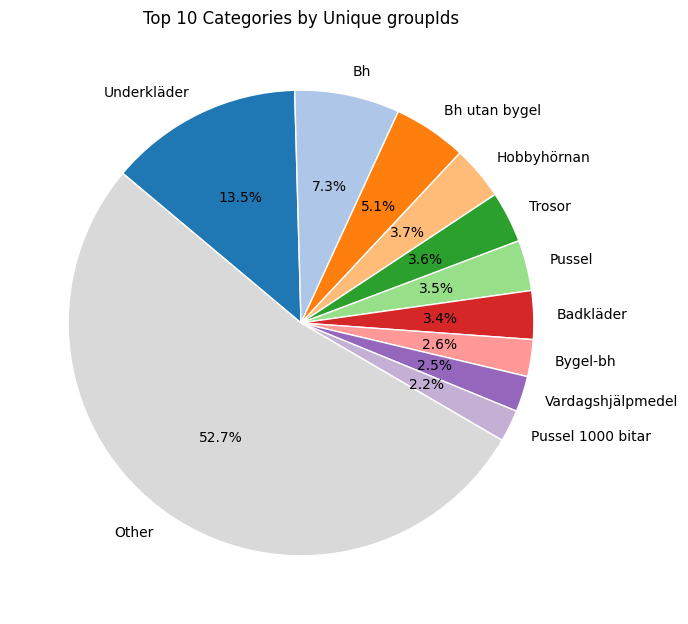

In [220]:
import matplotlib.pyplot as plt

# Explode comma-separated categories, strip, and drop empty
df = articles_clean.copy()
df['category'] = df['category'].fillna('').str.split(',')
df = df.explode('category')
df['category'] = df['category'].str.strip()
df = df[df['category'] != '']

# Calculate unique groupId coverage per category
total_groups = df['groupId'].nunique()
cat_cov = df.groupby('category')['groupId'].nunique().sort_values(ascending=False)
top_n = 10
top = cat_cov.head(top_n)
other = cat_cov.iloc[top_n:].sum()
labels = list(top.index) + ['Other']
sizes = list(top.values) + [other]

# Aesthetic color palette (e.g., pastel)
colors = plt.get_cmap('tab20').colors[:top_n] + ((0.85, 0.85, 0.85),)

plt.figure(figsize=(7,7))
plt.pie(
    sizes, labels=labels, autopct='%1.1f%%', startangle=140,
    counterclock=False, colors=colors, wedgeprops={'edgecolor':'w'}
)
plt.title('Top 10 Categories by Unique groupIds')
plt.tight_layout()
plt.show()


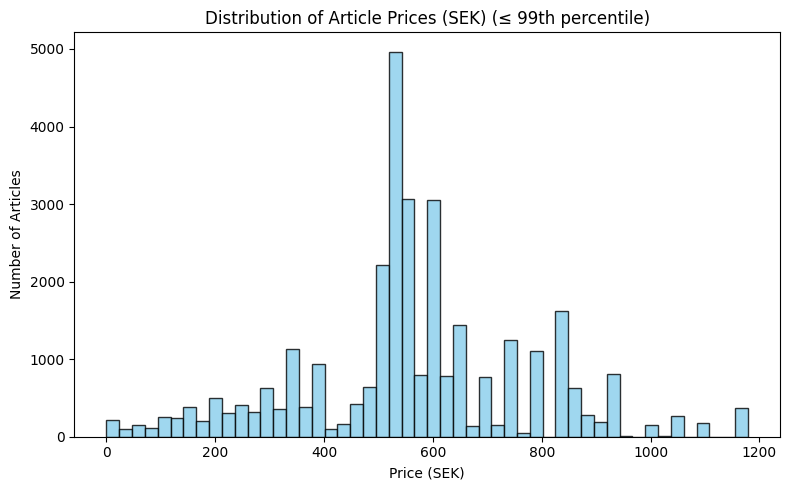

In [221]:
# Plot price distribution (SEK) for articles with valid price, limiting the long tail
import numpy as np

prices = pd.to_numeric(articles_clean['priceSEK'], errors='coerce').dropna()

# Limit to 99th percentile to avoid long tail interference
upper = np.percentile(prices, 99)
filtered_prices = prices[prices <= upper]

plt.figure(figsize=(8,5))
plt.hist(filtered_prices, bins=50, color='skyblue', edgecolor='k', alpha=0.8)
plt.xlabel('Price (SEK)')
plt.ylabel('Number of Articles')
plt.title('Distribution of Article Prices (SEK) (≤ 99th percentile)')
plt.tight_layout()
plt.show()